In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.sparse.linalg import cg

In [2]:
from scipy.io import mmread, loadmat
A = loadmat("C:/Users/Guechchani/Desktop/Research/phd_/A66")["Ast"].toarray()

In [3]:
#Steepest gradient
def SDG(A,b,iter_max,tol,x=0):
    r=b.copy()
    iter=0
    err=np.linalg.norm(r)
    L=[np.linalg.norm(r)]
    while iter<iter_max and err>tol:
        iter+=1
        Ar=A@r   #Ar_k
        err2=np.dot(r,r)
        alpha=err2/np.dot(Ar,r)
        x += alpha*r
        r -= alpha*Ar
        err=np.sqrt(err2)
    
        L.append(err)
    return L,iter


#Conjugate gradient
def CG(A,b,iter_max,tol,x=0):
    r   =b.copy()
    p   =b.copy()
    iter=0
    err=np.linalg.norm(r)
    L   =[err]
    while iter<iter_max and err>tol:
        iter+= 1
        rk2  = np.dot(r,r)
        alpha= rk2/np.dot(A@p,p)
        x   += alpha*p
        r   -= alpha*A@p
        beta = np.dot(r,r)/rk2
        p    = r + beta*p
        err  = np.linalg.norm(r)
        L.append(err)
    return L,iter,x

#Arnoldi
def FOM(A,b,m,tol, x=0):
    residuals=[]
    r     = b.copy()
    e1    = np.zeros(m)
    e1[0] = np.linalg.norm(r)
    V     = np.zeros((len(b),m+1))
    V[:,0]= r/e1[0]
    H     = np.zeros((m+1,m))
    for j in range (0,m):
        w = A @ V[:, j]
        for i in range (0,j+1):
            H[i, j] = np.dot(V[:, i], w)  
            w -= H[i, j] * V[:, i]
        H[j+1,j]=np.linalg.norm(w)
        if  H[j+1,j]==0 : break
        V[:, j+1] = w / H[j+1, j]
        x_m = V[:, :j+1] @ np.linalg.solve(H[:j+1, :j+1], e1[:j+1])
        residual = np.linalg.norm(b - A @ x_m)
        if residual<tol :
            return residuals, x_m
        residuals.append(residual)
    return residuals,x_m


#GMRES
def gmres(A,b,m,tol,x=0):
    residuals=[]
    r     = b.copy()
    e1    = np.zeros(m+1)
    e1[0] = np.linalg.norm(r)
    V     = np.zeros((len(b),m+1))
    V[:,0]= r/e1[0]
    H     = np.zeros((m+1,m))
    for j in range (0,m):
        w = A @ V[:, j]
        for i in range (0,j+1):
            H[i, j] = np.dot(V[:, i], w)  
            w -= H[i, j] * V[:, i]
        H[j+1,j]=np.linalg.norm(w)
        if  H[j+1,j]==0 : break
        V[:, j+1] = w / H[j+1, j]
        x_m = V[:, :j+1]@ np.linalg.lstsq(H[:j+2, :j+1], e1[:j+2],rcond=None)[0]
        residual = np.linalg.norm(b - A @ x_m)
        if residual<tol :
            return residuals, x_m
        residuals.append(residual)
    return residuals, x_m

**Example 1 :** Let's set $b=\begin{pmatrix} 1 \\ 1 \\ \vdots \\ 1 \end{pmatrix}$

In [4]:
b=np.ones(A.shape[0])
#Steepest
start = time.time()
x_SDG=SDG(A,b,iter_max=4000,tol=1e-6,x=0)
end = time.time()
print('SDG execution time :',end - start)
print('SDG max_iter :',len(x_SDG[0]))

#Conjugate
start = time.time()
x_CG=CG(A,b,iter_max=4000,tol=1e-7,x=0)
end = time.time()
print('CG execution time :',end - start)
print('CG max_iter :',len(x_CG[0]))
#Full ortho
start = time.time()
x_FOM=FOM(A,b,500,1e-6,x=0)
end = time.time()
print('FOM execution time :',end - start)
print('FOM max_iter :',len(x_FOM[0]))

#GMRES
start = time.time()
x_gmres=gmres(A,b,500,1e-6,x=0)
end = time.time()
print('GMRES execution time :', end - start)
print('GMRES max_iter :',len(x_gmres[0]))


#direct
start = time.time()
w=np.linalg.solve(A,b)
end = time.time()
print('execution time :', end - start)

SDG execution time : 184.61959671974182
SDG max_iter : 4001
CG execution time : 38.410353660583496
CG max_iter : 90
FOM execution time : 8.563080072402954
FOM max_iter : 82
GMRES execution time : 8.068722009658813
GMRES max_iter : 82
execution time : 4.17130970954895


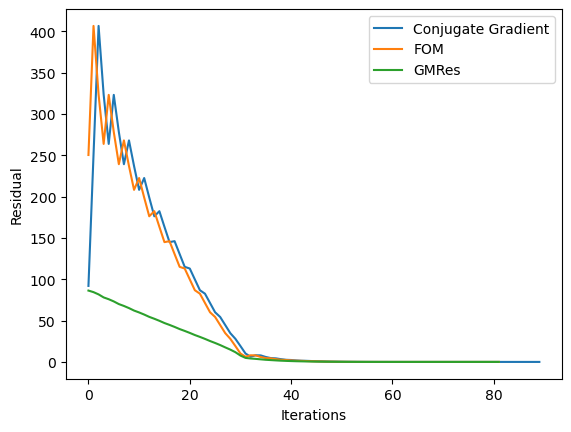

In [5]:
#plt.plot(x_SDG[0])
plt.plot(x_CG[0],label='Conjugate Gradient')
plt.plot(x_FOM[0], label='FOM')
plt.plot(x_gmres[0], label = 'GMRes')
plt.xlabel('Iterations')
plt.ylabel('Residual')
plt.legend()